/content/prepare_data_for_modal.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_stock1_data['Month'][i] = int(pre_stock1_data['Date'][i].split('/')[1])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7)                 63        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________
Train on 360 samples, validate on 40 samples
Epoch 1/950
360/360 [==============================] - 0s 398us/step - loss: 9560.7944 - acc: 0.1083 - val_loss: 14023.7368 - val_acc: 0.1250

Epoch 00001: val_loss improved from inf to 14023.73682, saving model to ./log/benchmark_1.best.hdf5
Epoch 2/950
360/360 [==============================] - 0s 243us/step - loss: 9528.0754 - acc: 0.1083 - val_loss: 13973.7112 - val_acc: 0.1250

Epoch 00002: val_loss improved from 14023.73682 to 13973.71118, saving model to ./log/benchmark_1.best.hdf5
Epoch 3/950
360/360 [==============================] - 0s 273us/step - loss: 9495.2641 - acc: 0.1083 - val_loss: 

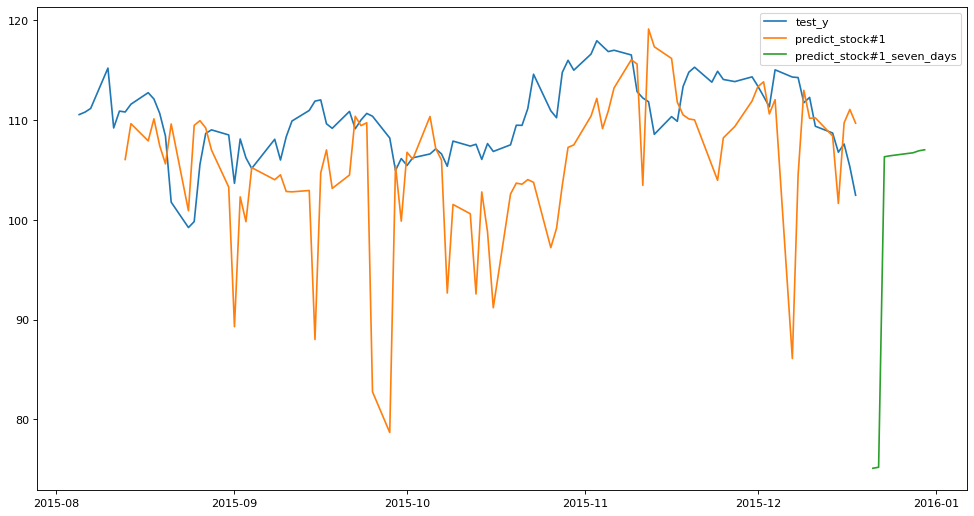

In [0]:
# get all the imports
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import PolynomialFeatures
from keras.models import load_model
from prepare_data_for_modal import prepare_data, series_to_supervised, split_sequence


pre_stock_data, stock, news = prepare_data('1')

poly=PolynomialFeatures(degree=3)
stock=poly.fit_transform(stock)

# Split the data into train and test data¶
train_x = np.hstack([stock[:400], news[:400]])
# y就是要被预测的价格
train_y = pre_stock_data.iloc[:406, 9:].values
train_y = series_to_supervised(train_y, 6, 1)

test_x = np.hstack([stock[400:], news[400:]])
test_y = pre_stock_data.iloc[400:, 9:].values

# make model
model=Sequential()
# layer 1
model.add(Dense(7,input_shape=train_x.shape[1:],activation='linear'))
# optimizer if needed
# opt=keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# to make the log of the data collected while training to see in the tensor board
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='./log/benchmark_1'+str(time), write_graph=True)
# to create the check points of the weights based on the best validation los
filepath="./log/benchmark_1.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

model.summary()
model.fit(
         train_x
        ,train_y
        ,epochs=950
        ,batch_size=10
        ,verbose=1
        ,validation_split=0.1
        ,callbacks=callbacks_list
        )

model=load_model('./log/benchmark_1.best.hdf5')
fig = plt.figure(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
predict_train=model.predict(train_x)
predict_test=model.predict(test_x)
a_score=(abs(predict_test-test_y)/test_y).sum()

predict_Date = ['2015/12/21', '2015/12/22', '2015/12/23', '2015/12/24', '2015/12/28', '2015/12/29', '2015/12/30']
dataArr = np.append(pre_stock_data['Date'], predict_Date)
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in dataArr]

predata = np.squeeze(predict_test[:, :1], axis=1)[0:-6]
day1 = np.squeeze(predict_test[:, :1], axis=1)[-1]
day2 = np.squeeze(predict_test[:, 1:2], axis=1)[-1]
day3 = np.squeeze(predict_test[:1, 2:3], axis=1)[-1]
day4 = np.squeeze(predict_test[:1, 3:4], axis=1)[-1]
day5 = np.squeeze(predict_test[:1, 4:5], axis=1)[-1]
day6 = np.squeeze(predict_test[:1, 5:6], axis=1)[-1]
day7 = np.squeeze(predict_test[:1, 6:7], axis=1)[-1]
predict_arr = np.round(np.array([day1, day2,day3, day4, day5, day6, day7]), 1)
print('predict_seven_days == ', predict_arr)
plt.plot(index[400:496],np.squeeze(test_y,axis=1), label='test_y')
plt.plot(index[406:496],np.squeeze(predata), label='predict_stock#1')
plt.plot(index[496:503],np.squeeze(predict_arr), label='predict_stock#1_seven_days')
plt.legend()
plt.show()

